In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Choose dataset: "mnist" or "fashion"
dataset_choice = "mnist"

if dataset_choice == "mnist":
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
else:
    (x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten images (28x28 -> 784)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

print("Training shape:", x_train.shape)
print("Testing shape:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training shape: (60000, 784)
Testing shape: (10000, 784)


In [3]:
latent_dim = 2  # use 2 for latent visualization

inputs = keras.Input(shape=(784,))
h = layers.Dense(256, activation="relu")(inputs)
h = layers.Dense(128, activation="relu")(h)

z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

In [5]:
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 234,372 (915.52 KB)

 Trainable params: 234,372 (915.52 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(784, activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,896 (917.56 KB)

 Trainable params: 234,896 (917.56 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs): # Added call method
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
        }

In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError()) # Added a dummy loss function

history = vae.fit(
    x_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, x_test) # Changed None to x_test for validation targets
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - kl_loss: 1.5945e-06 - loss: 0.2631 - reconstruction_loss: 0.2631 - val_loss: 0.0675
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.3701e-07 - loss: 0.2631 - reconstruction_loss: 0.2631 - val_loss: 0.0676
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 1.5043e-07 - loss: 0.2630 - reconstruction_loss: 0.2630 - val_loss: 0.0675
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 6.6526e-08 - loss: 0.2631 - reconstruction_loss: 0.2631 - val_loss: 0.0675
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 9.1528e-08 - loss: 0.2630 - reconstruction_loss: 0.2630 - val_loss: 0.0675
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 6.9928e-08 - loss: 0.2630 - reconstruction_loss: 0.2630 - val_loss: 0.0675
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.1418e-08 - loss: 0.2630 - reconstruction_loss: 0.2630 - val_loss: 0.0675
Epoch 8/30
469/469 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


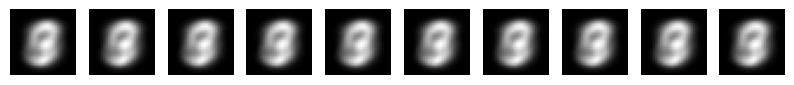

In [17]:
def plot_generated_images(decoder, n=10):
    z_random = np.random.normal(size=(n, latent_dim))
    generated = decoder.predict(z_random)

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

plot_generated_images(decoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


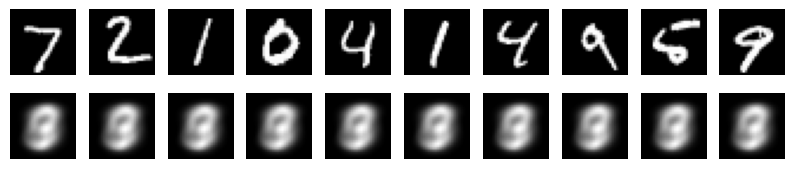

In [18]:
z_mean, _, z = encoder.predict(x_test[:10])
reconstructed = decoder.predict(z)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


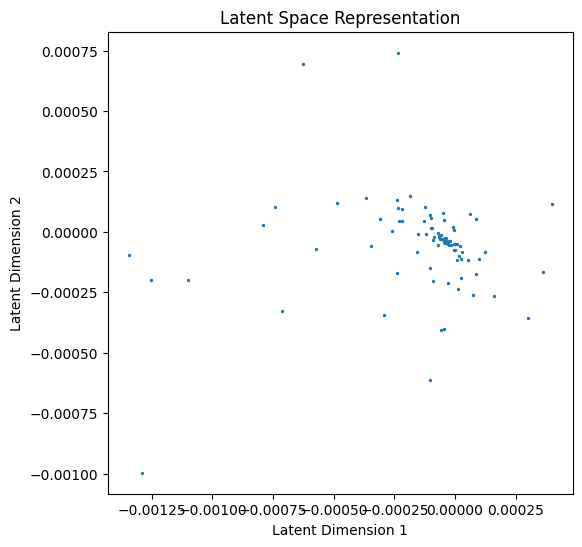

In [19]:
z_mean, _, _ = encoder.predict(x_test)

plt.figure(figsize=(6, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], s=2)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Representation")
plt.show()